<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Text_classification_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 Training sequences
25000 Validation sequences


In [ ]:
class TransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
    super(TransformerBlock, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential([
                                 layers.Dense(ff_dim, activation='relu'),
                                 layers.Dense(embed_dim)
    ])
    self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training = training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training = training)
    return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim = embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
      maxlen = tf.shape(x)[-1]
      positions = tf.range(start=0, limit=maxlen, delta=1)
      positions = self.pos_emb(positions)
      x = self.token_emb(x)
      return x + positions

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape = (maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block (Transform (None, 200, 32)           10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

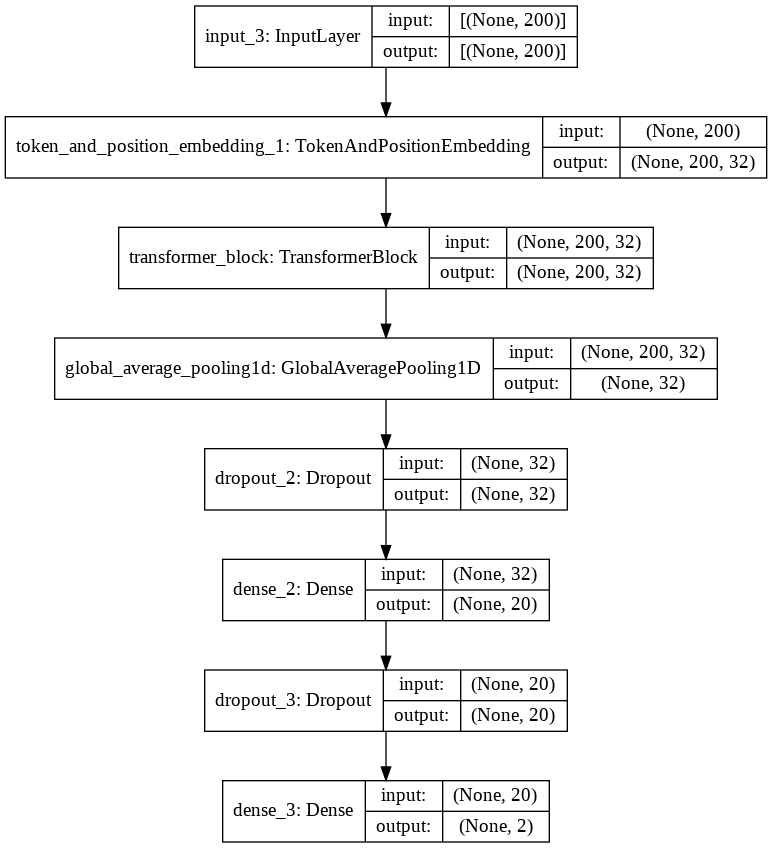

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 131s 165ms/step - loss: 0.5161 - accuracy: 0.7093 - val_loss: 0.3041 - val_accuracy: 0.8680
Epoch 2/2
782/782 [==============================] - 128s 164ms/step - loss: 0.1874 - accuracy: 0.9302 - val_loss: 0.3048 - val_accuracy: 0.8748


In [ ]:
layer = layers.MultiHeadAttention(num_heads=2, key_dim=2)

In [ ]:
layer()